# Random Forest Hyperparameter Tuning

This notebook implements and tunes a Random Forest classifier for wildfire detection using NASA satellite measurement data.

In [2]:
# Standard library imports
import os

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split

# Configuration
DATA_PATH = "../data/final_combined_dataset.csv"
RANDOM_STATE = 1234
TEST_SIZE = 0.2

# Load dataset
data = pd.read_csv(DATA_PATH)

# Prepare features and target
X = data.drop(["FIRE", "Date"], axis=1)
y = data['FIRE']

# Split data into training and testing sets
X_train, X_test, y_train, y_test, data_train, data_test = train_test_split(
    X, y, data, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Display dataset shapes
print("Dataset splits:")
print(f"  Training set: {X_train.shape}")
print(f"  Test set:     {X_test.shape}")
print(f"\nLabel shapes:")
print(f"  Training labels: {y_train.shape}")
print(f"  Test labels:     {y_test.shape}")

Dataset splits:
  Training set: (23960, 12)
  Test set:     (5990, 12)

Label shapes:
  Training labels: (23960,)
  Test labels:     (5990,)


,name,Training Accuracy,Eval Accuracy,Training Recall,Eval Recall,Training Precision,Eval Precision,Training F1,Eval F1,Training ROC,Eval ROC
0,Random Forest,1.0,0.974124,1.0,0.979564,1.0,0.968024,1.0,0.97376,1.0,0.994425


Generating visualizations for Random Forest...


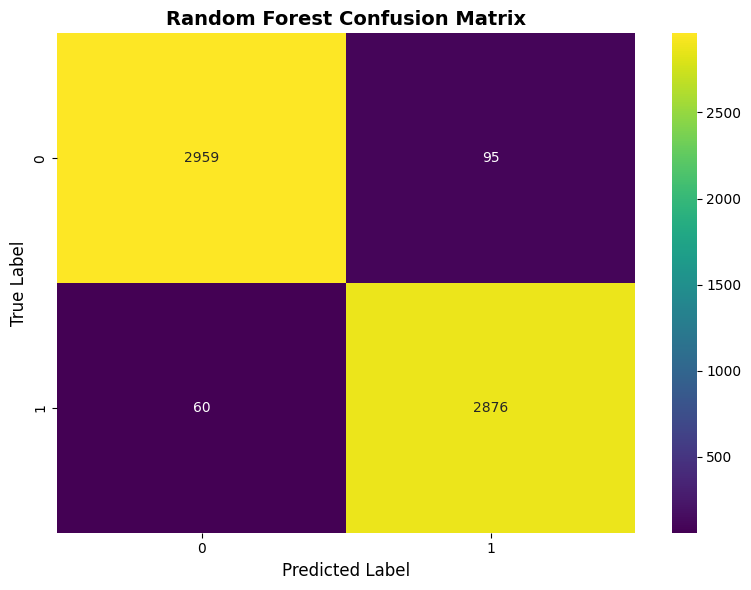

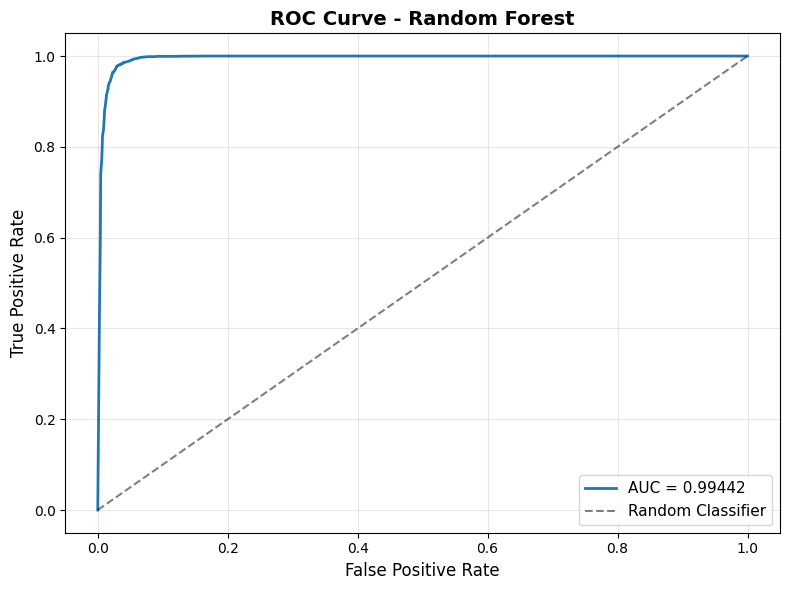

In [3]:
# Scikit-learn imports
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)


def evaluate_pipelines(pipelines, X_train, y_train, X_evaluate, y_evaluate):

    rows = []
    for name, pipeline in pipelines:
        # Fit pipeline on training data
        pipeline.fit(X_train, y_train)
        
        # Generate predictions
        train_preds = pipeline.predict(X_train)
        eval_preds = pipeline.predict(X_evaluate)
        
        # Get probabilities for ROC-AUC calculation
        train_probs = pipeline.predict_proba(X_train)[:, 1]
        eval_probs = pipeline.predict_proba(X_evaluate)[:, 1]
        
        # Calculate metrics
        rows.append({
            'name': name,
            'Training Accuracy': accuracy_score(y_train, train_preds),
            'Eval Accuracy': accuracy_score(y_evaluate, eval_preds),
            'Training Recall': recall_score(y_train, train_preds),
            'Eval Recall': recall_score(y_evaluate, eval_preds),
            'Training Precision': precision_score(y_train, train_preds),
            'Eval Precision': precision_score(y_evaluate, eval_preds),
            'Training F1': f1_score(y_train, train_preds),
            'Eval F1': f1_score(y_evaluate, eval_preds),
            'Training ROC': roc_auc_score(y_train, train_probs),
            'Eval ROC': roc_auc_score(y_evaluate, eval_probs)
        })
    
    return pd.DataFrame(rows)


def plot_confusion_matrix(y_true, y_pred, clf_name):

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='viridis')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'{clf_name} Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_probs, clf_name=""):

    auc = roc_auc_score(y_true, y_probs)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.5f}", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    title = f"ROC Curve - {clf_name}" if clf_name else "ROC Curve"
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# Initialize baseline Random Forest model
random_forest = make_pipeline(
    RandomForestClassifier(random_state=RANDOM_STATE)
)

# Evaluate baseline model
baseline_results = evaluate_pipelines(
    [('Random Forest', random_forest)],
    X_train, y_train, X_test, y_test
)
display(baseline_results)

# Generate visualizations
print("Generating visualizations for Random Forest...")
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
y_probs = random_forest.predict_proba(X_test)[:, 1]
plot_confusion_matrix(y_test, y_pred, "Random Forest")
plot_roc_curve(y_test, y_probs, "Random Forest")

## Hyperparameter Tuning

Tune Random Forest based on the following parameters:
- max_depth
- min_samples_leaf

Utilize Cross-Validation for hyperparameter tuning

Performing grid search for Random Forest...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/paul/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2}
Best CV Score: 0.994985


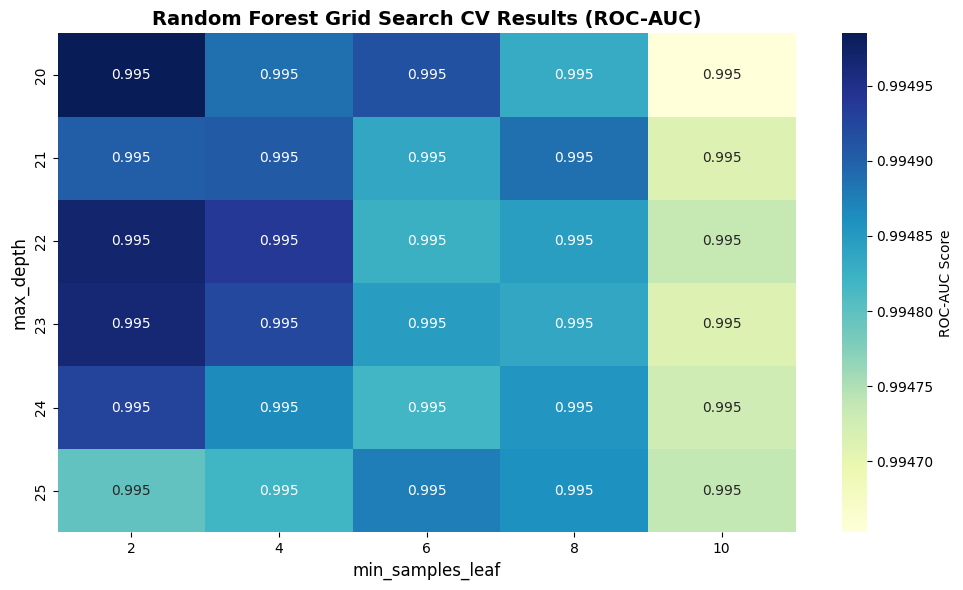

In [4]:
# Hyperparameter tuning for Random Forest
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
rf_param_grid = {
    'max_depth': [20, 21, 22, 23, 24, 25],
    'min_samples_leaf': [2, 4, 6, 8, 10]
}

# Perform grid search with 5-fold cross-validation
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid=rf_param_grid,
    cv=5,
    scoring='roc_auc_ovo',
    n_jobs=-1,
    verbose=1
)

print("Performing grid search for Random Forest...")
rf_grid_search.fit(X_train, y_train)

# Display best parameters
print(f"\nBest Parameters: {rf_grid_search.best_params_}")
print(f"Best CV Score: {rf_grid_search.best_score_:.6f}")

# Visualize grid search results
results_df = pd.DataFrame(rf_grid_search.cv_results_)
pivot_table = results_df.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_leaf'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'ROC-AUC Score'})
plt.title('Random Forest Grid Search CV Results (ROC-AUC)', fontsize=14, fontweight='bold')
plt.xlabel('min_samples_leaf', fontsize=12)
plt.ylabel('max_depth', fontsize=12)
plt.tight_layout()
plt.show()

## Final Evaluation

Compare base and tuned Random Forest models.

Comparing base and tuned Random Forest models:


,name,Training Accuracy,Eval Accuracy,Training Recall,Eval Recall,Training Precision,Eval Precision,Training F1,Eval F1,Training ROC,Eval ROC
0,Base Random Forest,1.000000,0.974124,1.000000,0.979564,1.000000,0.968024,1.000000,0.973760,1.000000,0.994425
1,Tuned Random Forest,0.994032,0.972788,0.998751,0.977180,0.989445,0.967622,0.994076,0.972378,0.999905,0.993816



Generating visualizations for Base Random Forest...


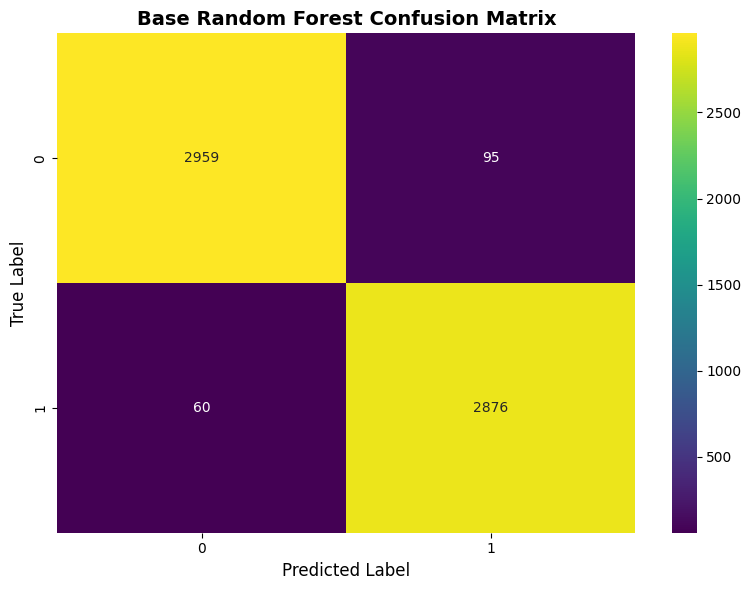

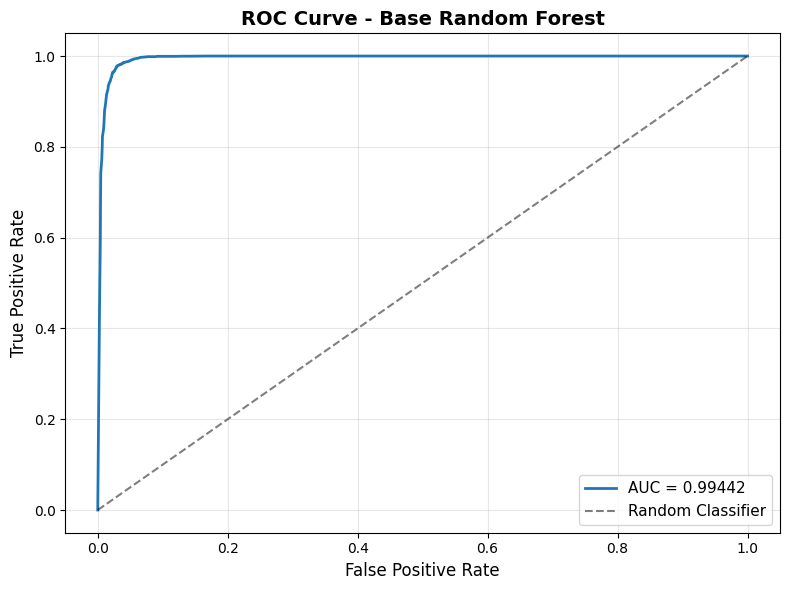


Generating visualizations for Tuned Random Forest...


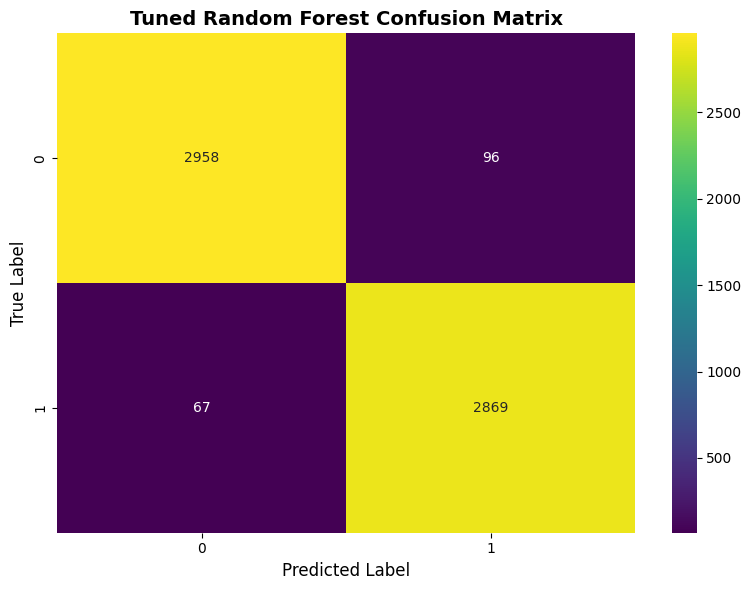

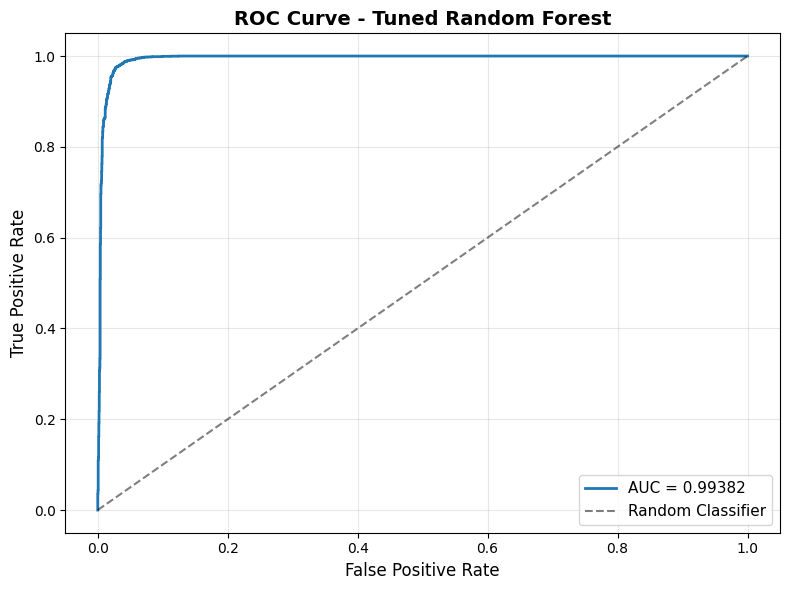

In [5]:
# Extract best hyperparameters
RF_BEST_MAX_DEPTH = rf_grid_search.best_params_['max_depth']
RF_BEST_MIN_SAMPLES_LEAF = rf_grid_search.best_params_['min_samples_leaf']

# Create base and tuned models
base_rf = make_pipeline(RandomForestClassifier(random_state=RANDOM_STATE))
tuned_rf = make_pipeline(RandomForestClassifier(
    random_state=RANDOM_STATE,
    max_depth=RF_BEST_MAX_DEPTH,
    min_samples_leaf=RF_BEST_MIN_SAMPLES_LEAF
))

# Evaluate models
print("Comparing base and tuned Random Forest models:")
comparison_results = evaluate_pipelines([
    ('Base Random Forest', base_rf),
    ('Tuned Random Forest', tuned_rf)
], X_train, y_train, X_test, y_test)
display(comparison_results)

# Generate visualizations
models_to_plot = [
    ('Base Random Forest', base_rf),
    ('Tuned Random Forest', tuned_rf)
]

for name, clf in models_to_plot:
    print(f"\nGenerating visualizations for {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)[:, 1]
    plot_confusion_matrix(y_test, y_pred, name)
    plot_roc_curve(y_test, y_probs, name)

## Scaling and Hyperparameter Tuning

Evaluate the impact of feature scaling on Random Forest performance.

Comparing base and scaled Random Forest models:


,name,Training Accuracy,Eval Accuracy,Training Recall,Eval Recall,Training Precision,Eval Precision,Training F1,Eval F1,Training ROC,Eval ROC
0,Base Random Forest,1.0,0.974124,1.0,0.979564,1.0,0.968024,1.0,0.973760,1.0,0.994425
1,Scaled Random Forest,1.0,0.974290,1.0,0.979564,1.0,0.968350,1.0,0.973925,1.0,0.994430



Generating visualizations for Base Random Forest...


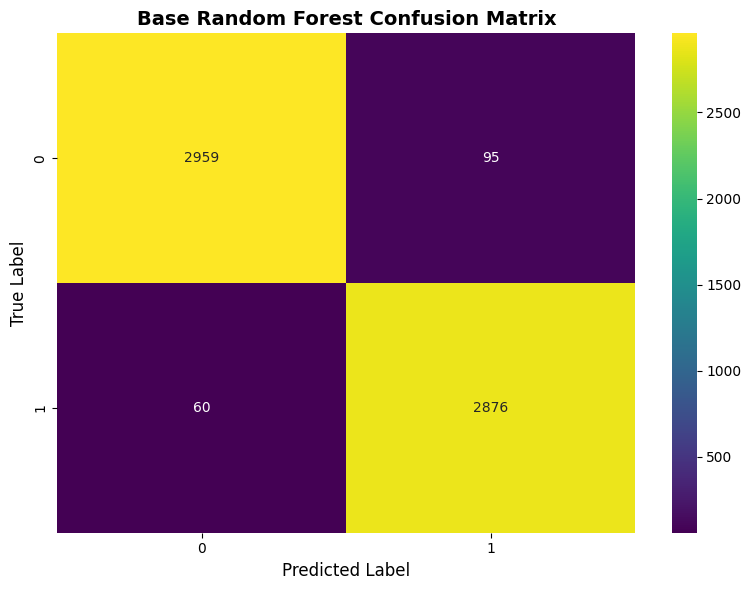

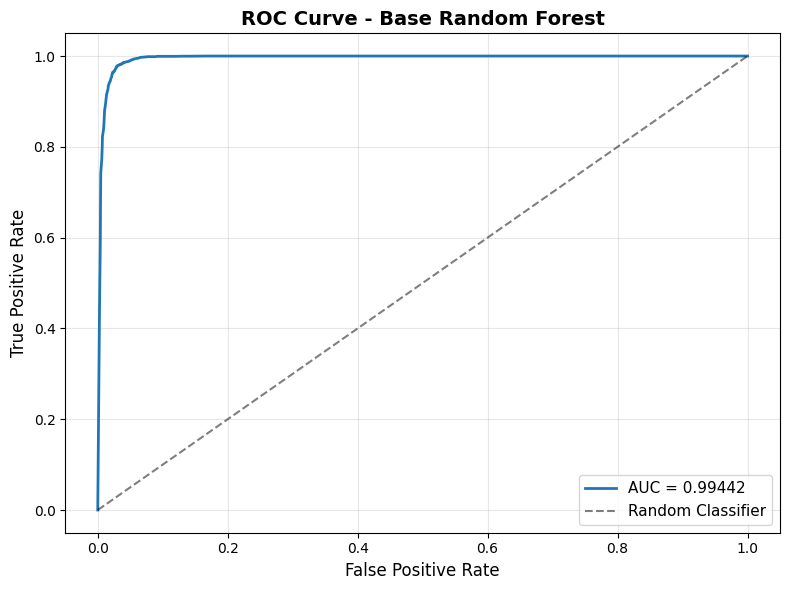


Generating visualizations for Scaled Random Forest...


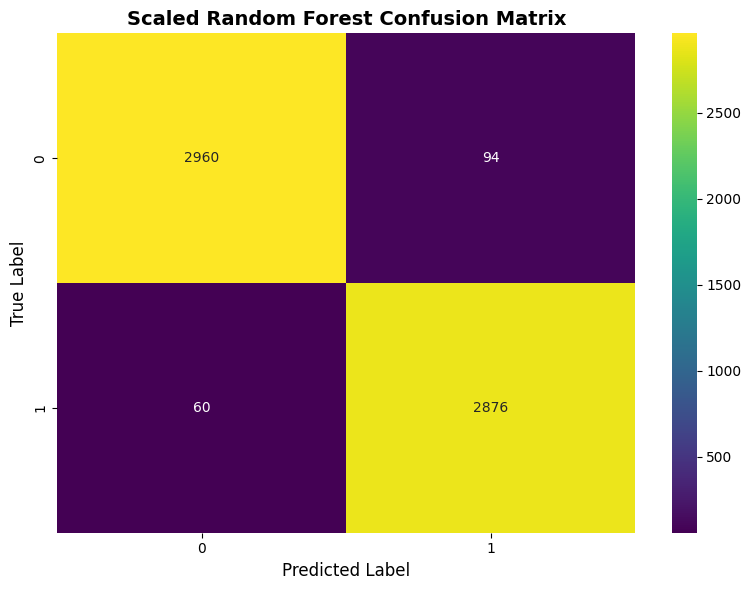

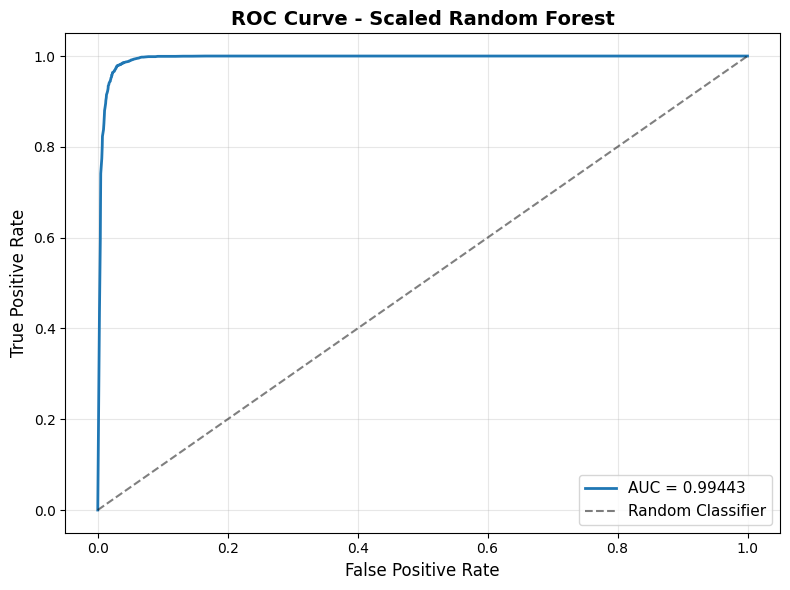

In [6]:
# Evaluate impact of feature scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Create base and scaled models
base_rf = make_pipeline(RandomForestClassifier(random_state=RANDOM_STATE))
scaled_rf = make_pipeline(scaler, RandomForestClassifier(random_state=RANDOM_STATE))

# Evaluate models
print("Comparing base and scaled Random Forest models:")
scaling_results = evaluate_pipelines([
    ('Base Random Forest', base_rf),
    ('Scaled Random Forest', scaled_rf)
], X_train, y_train, X_test, y_test)
display(scaling_results)

# Generate visualizations
models_to_plot = [
    ('Base Random Forest', base_rf),
    ('Scaled Random Forest', scaled_rf)
]

for name, clf in models_to_plot:
    print(f"\nGenerating visualizations for {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)[:, 1]
    plot_confusion_matrix(y_test, y_pred, name)
    plot_roc_curve(y_test, y_probs, name)

## Scaled and Tuned Model

Combine feature scaling with hyperparameter tuning.

Comparing all Random Forest model variants:


,name,Training Accuracy,Eval Accuracy,Training Recall,Eval Recall,Training Precision,Eval Precision,Training F1,Eval F1,Training ROC,Eval ROC
0,Base Random Forest,1.00000,0.974124,1.000000,0.979564,1.000000,0.968024,1.000000,0.973760,1.000000,0.994425
1,Scaled Random Forest,1.00000,0.974290,1.000000,0.979564,1.000000,0.968350,1.000000,0.973925,1.000000,0.994430
2,Scaled and Tuned Random Forest,0.99399,0.972788,0.998751,0.977180,0.989363,0.967622,0.994035,0.972378,0.999904,0.993815



Generating visualizations for Base Random Forest...


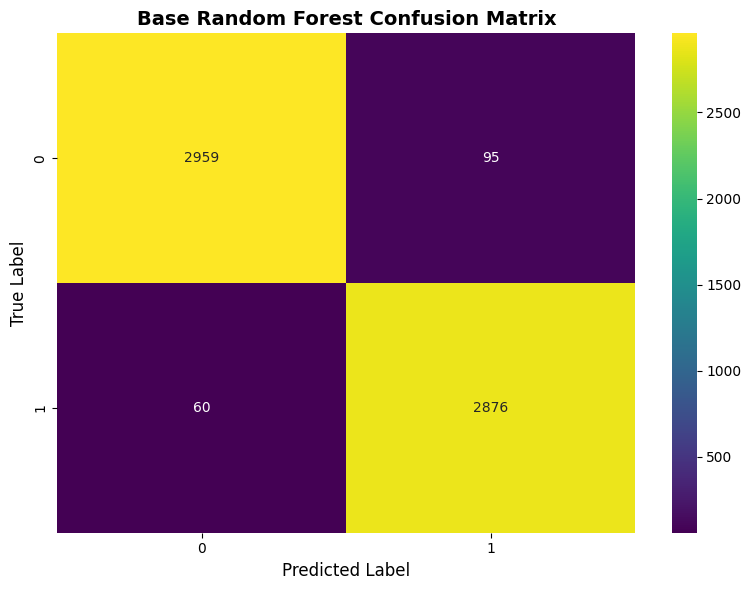

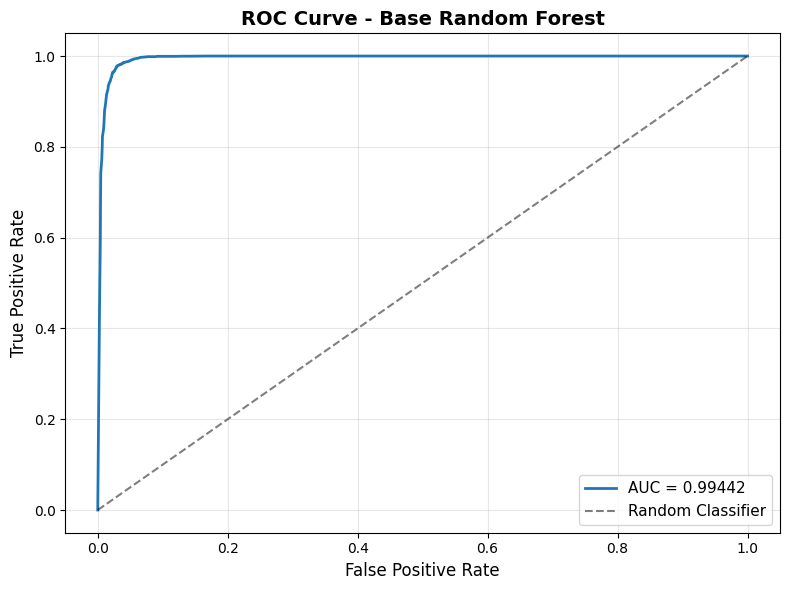


Generating visualizations for Scaled Random Forest...


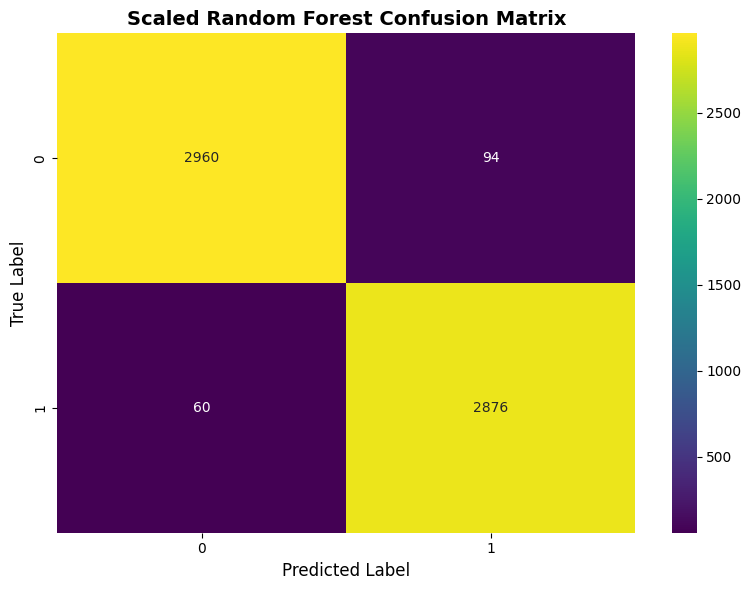

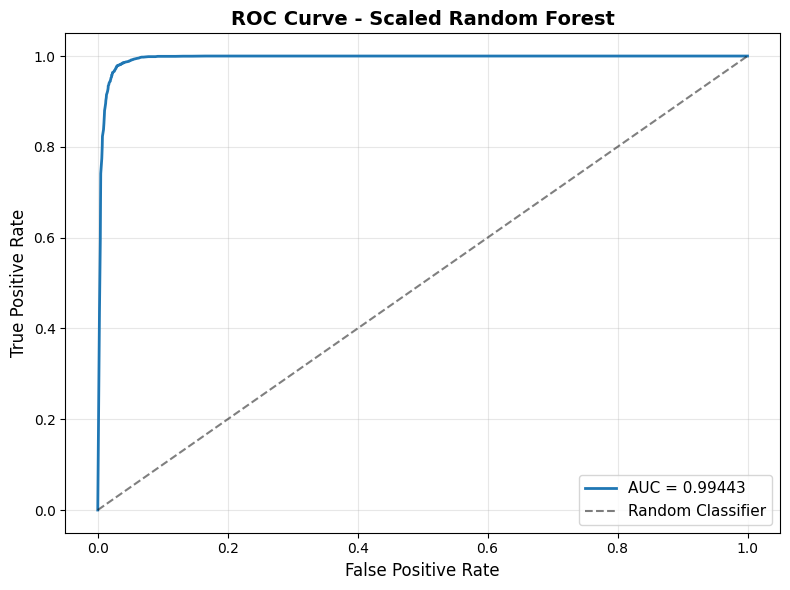


Generating visualizations for Scaled and Tuned Random Forest...


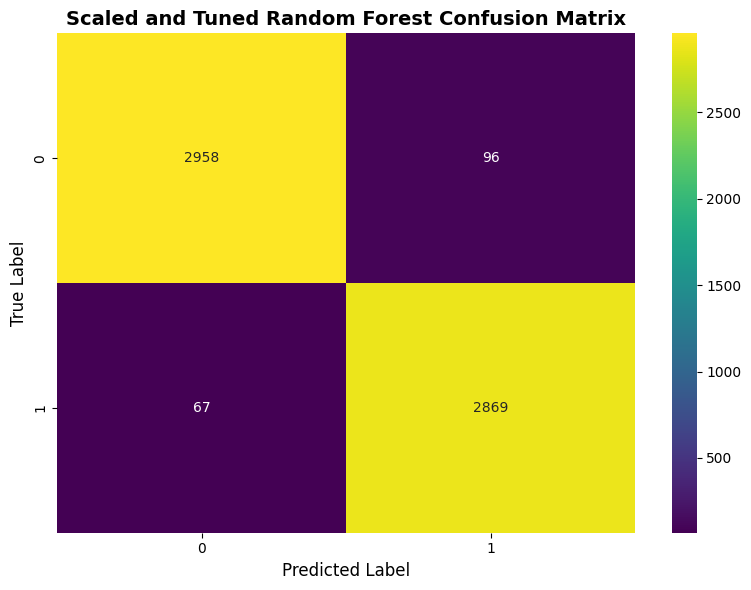

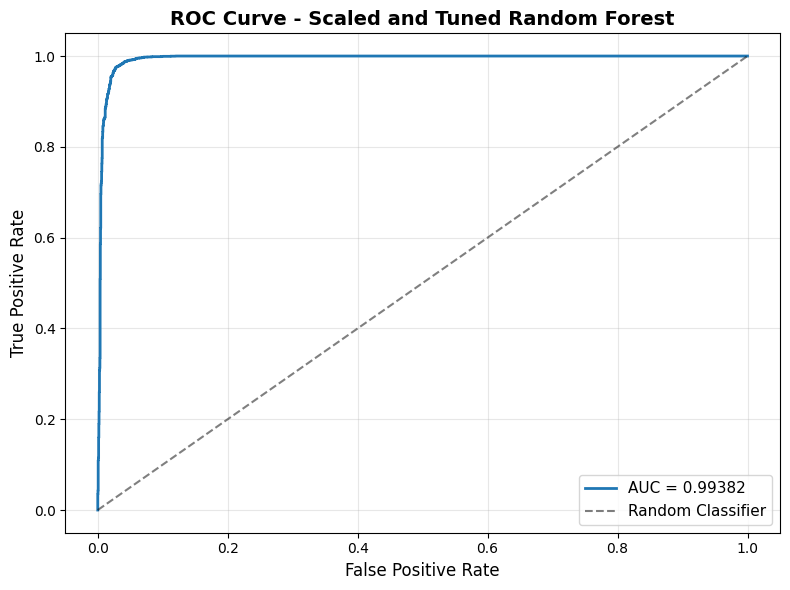

In [7]:
# Create scaled and tuned model
tuned_rf = make_pipeline(
    scaler,
    RandomForestClassifier(
        random_state=RANDOM_STATE,
        max_depth=RF_BEST_MAX_DEPTH,
        min_samples_leaf=RF_BEST_MIN_SAMPLES_LEAF
    )
)

# Evaluate all model variants
print("Comparing all Random Forest model variants:")
final_results = evaluate_pipelines([
    ('Base Random Forest', base_rf),
    ('Scaled Random Forest', scaled_rf),
    ('Scaled and Tuned Random Forest', tuned_rf)
], X_train, y_train, X_test, y_test)
display(final_results)

# Generate visualizations for all models
models_to_plot = [
    ('Base Random Forest', base_rf),
    ('Scaled Random Forest', scaled_rf),
    ('Scaled and Tuned Random Forest', tuned_rf)
]

for name, clf in models_to_plot:
    print(f"\nGenerating visualizations for {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)[:, 1]
    plot_confusion_matrix(y_test, y_pred, name)
    plot_roc_curve(y_test, y_probs, name)

## Summary

Using cross-validation to tune the hyperparameters of the Random Forest model, we note improvements in the ROC-AUC score. The tuned model shows enhanced performance for wildfire risk prediction, which is our main goal for forecasting risk levels for wildfire outbreak.

## Feature Importance

In [8]:
# Feature importance analysis using permutation importance
from sklearn.inspection import permutation_importance

# Calculate permutation importance for Random Forest
print("Calculating permutation importance for Random Forest...")
rf_perm = permutation_importance(
    estimator=tuned_rf,
    X=X_test,
    y=y_test,
    n_repeats=15,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Format results as DataFrame
rf_perm_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': rf_perm.importances_mean,
    'Std': rf_perm.importances_std
}).sort_values('Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print("=" * 60)
display(rf_perm_df)

Calculating permutation importance for Random Forest...

Random Forest Feature Importance:


,Feature,Importance,Std
8,PS,0.128214,0.003349
1,Longitude,0.055590,0.002036
0,Latitude,0.045192,0.001648
4,T2M_MAX,0.001577,0.000355
7,RH2M,0.001561,0.000310
2,WS2M,0.001406,0.000382
6,T2MDEW,0.000865,0.000356
3,T2M,0.000777,0.000321
11,ALLSKY_SFC_SW_DIFF,0.000595,0.000214
10,ALLSKY_SFC_SW_DWN,0.000346,0.000232


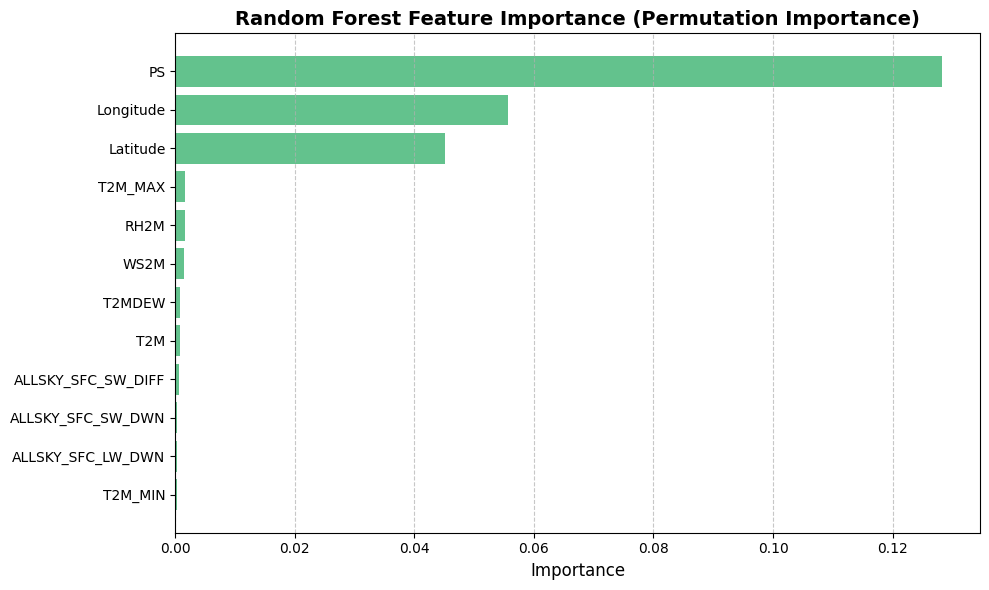

In [9]:
# Visualize Random Forest feature importance
plt.figure(figsize=(10, 6))
plt.barh(rf_perm_df['Feature'], rf_perm_df['Importance'], color='mediumseagreen', alpha=0.8)
plt.xlabel('Importance', fontsize=12)
plt.title('Random Forest Feature Importance (Permutation Importance)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Most important at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()